In [1]:
import numpy as np
import random as r
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend

In [4]:
def plot(I, O, **kwargs):
    count = 2 + len(kwargs)
    fig, axes = plt.subplots(count, 1, sharex=True,figsize=(12,3))
    ax1=axes[0]
    ax2=axes[1]

    ax1.step(time, I, 'b-') # y label
    ax2.step(time, O, 'r-')
   

    axes[-1].set_xlabel('time') # x label

    ax1.set_ylabel('Input', color='b')
    ax2.set_ylabel('Output', color='r')
    
    c = 2
    for k, v in kwargs.items():
        ax = axes[c]
        c+=1
        ax.step(time,v)
        ax.set_ylabel(k)
        
    plt.show()   

In [54]:
# const
BITS =8
MASK = (1<<BITS) - 1
MIN_FATIGUE=1


def ones(value):
    n = 0
    while value:
        n += 1
        value &= value-1
    return n

class Neuron:
    def __init__(self, min_threshold, uid):
        self.uid = uid
        self.state = 0
        self.min_threshold = min_threshold
        self.threshold = min_threshold
        self.recovery = 0
        self.targets = []
        self.inbox = 0
        
        self.fired = 0
    
    def enqueue(self, signal):
        self.inbox |= signal

    def process(self, epoch):
        signal = self.inbox
        self.inbox = 0
        
        def log(msg):
            if self.uid == 0:
                print(msg)
                
        
        self.state = ((self.state << 1) | signal) & MASK


        self.threshold = min(self.threshold, BITS)
        activate = ones(self.state & MASK) >= self.threshold

        if activate:
            for t in self.targets:
                t.enqueue()

            self.state = 0
            self.threshold += 1
            self.recovery=0
            self.fired = 1

        else:
            self.fired = 0

        if self.recovery>=(self.threshold+4):
            self.recovery=0
            self.threshold=max(self.min_threshold, self.threshold-1)    

        if self.threshold:
            self.recovery+=1
        
    pass


class Cleft:
    def __init__(self, neuron, delay):
        self.neuron = neuron
        self.delay = delay
        
        
        self.inbox = [0] * delay
        self.pointer = 0
        
    def enqueue(self):
        self.inbox[self.pointer] = 1
        
    def process(self, epoch):
        self.pointer = (self.pointer + 1) % len(self.inbox)
        self.neuron.enqueue(self.inbox[self.pointer])
        self.inbox[self.pointer] = 0

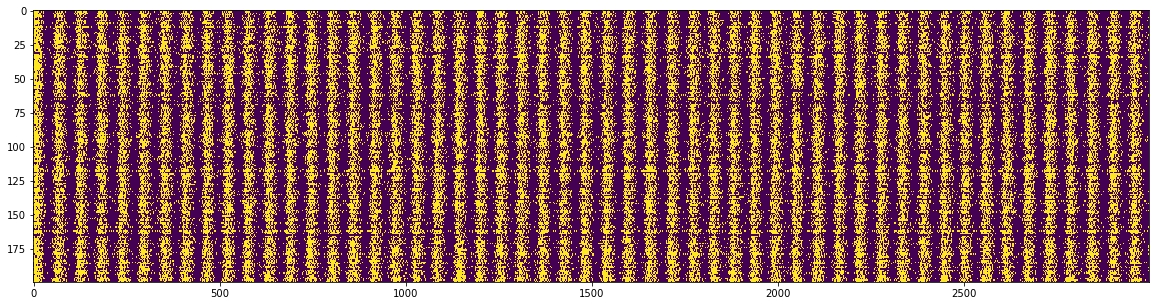

In [61]:
time=np.arange(0, 3000,1)
size = ((len(time)))
I=np.zeros(size)
O=np.zeros(size)
d1=np.zeros(size)
d2=np.zeros(size)

neurons = [Neuron((i % 3), i) for i in range(200)]
# connect neurons randomly


fires = np.zeros((len(time), len(neurons)))


clefts = []
for n in neurons:
    targets = r.sample(neurons, r.randint(3,10))
    for t in targets:
        c = Cleft(t, r.randint(1,5))
        n.targets.append(c) 
        clefts.append(c)

fired = 0

for n in neurons[0:10]:
    n.enqueue(1)
for i in time:
    neuron_inbox = 0
    cleft_inbox = 0
    for n in neurons:
        if n.inbox:
            fires[i][n.uid]=255
            #fires[i][n.uid]=ones(n.state)
            neuron_inbox+=1
            O[i]+=1
        
        n.process(i)
        if n.fired:
            fired += 1
    for c in clefts:
        if c.inbox:
            cleft_inbox +=1
        c.process(i)
    
        
    #print(f"N:{neuron_inbox} C:{cleft_inbox}")
plt.figure(figsize = (20,5))
_ = plt.imshow(fires.T, interpolation='none', aspect='auto')
plt.show()



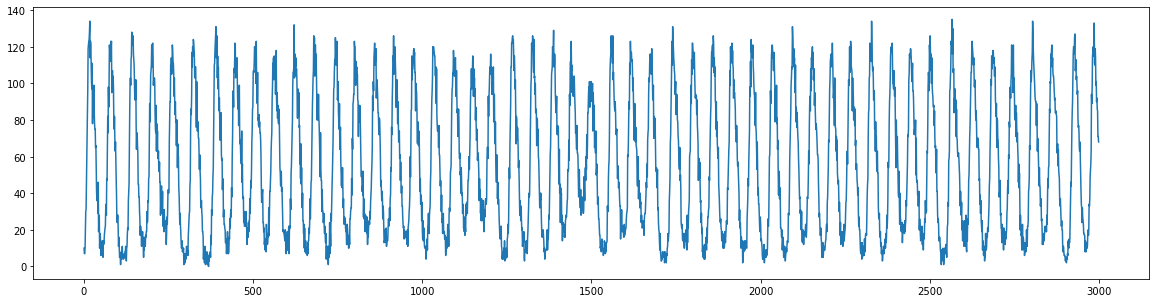

In [59]:
plt.figure(figsize = (20,5))
_ = plt.plot(O)